In [91]:
# [CLEAR VARIABLES]
%reset

In [92]:
# RESOURCES

# [IMPORT PACKAGES]
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# [IMPORT DATASET]
ks = pd.read_csv('ks2018.csv')
print("-"*100,'\nData set: {} samples'.format(ks.shape[0]))
print("-"*100)

# [NULL DATA]
print('Null values:')
print(ks.isnull().sum())
print("-"*100)
print('Percentage missing for "name" %.4f%%' %((ks['name'].isnull().sum()/ks.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((ks['usd pledged'].isnull().sum()/ks.shape[0])*100))
print("-"*100)

# [POSSIBLE OUTCOMES]
print('Outcomes: ', list(ks.state.unique()))
print("-"*100)

# [LIVE PROJECTS]
live = ks.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
print('The amount of live projects is: ', len(live[live == True].index))
print('This is %.2f%% of the total projects' %((len(live[live == True].index)/ks.shape[0])*100))
print("-"*100)

pd.set_option('display.max_columns', None)

---------------------------------------------------------------------------------------------------- 
Data set: 378661 samples
----------------------------------------------------------------------------------------------------
Null values:
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
----------------------------------------------------------------------------------------------------
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
----------------------------------------------------------------------------------------------------
Outcomes:  ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']
----

In [93]:
# DATA [CORRECTION, COMPLETION, CONVERSION, DELETION]

# remove live projects (0.74% of all data)
ks = ks.query('state != "live"')

# set state to 1 if successful, 0 otherwise, 1 is used for the 'rare class', there are more failed projects thant successful projects
ks['outcome'] = (ks['state'] == 'successful').astype(float)

# remove projects with null names (0.0011% of all data)
ks.drop(ks[ks.name.isnull()].index, axis=0, inplace=True, errors='ignore')

# remove outliers: goal over 30 000 000 (unrealistic, jokes)
ks.drop(ks[ks.goal > 30000000].index, inplace=True, errors='ignore')

# convert launched and deadline columns to datetime objects
ks['launched'] = pd.to_datetime(ks['launched'])
ks['deadline'] = pd.to_datetime(ks['deadline'])

# give unix-time anomalies a new launch date, 30 days before deadline (median, in order to not mess with data)
ks.loc[pd.DatetimeIndex(ks['launched']).year < 2000, 'launched'] = ks['deadline'] - pd.to_timedelta(30, unit='d')



In [94]:
# FEATURE [CREATION, ENGINEERING]
from sklearn.preprocessing import LabelEncoder

# log transformation on goal column
ks['goal'] = np.log(ks.goal)

# create titlelength feature (length of the project name)
ks['tlength'] = ks['name'].str.len()

# create duration feature (campaign duration in days, rounded up)
ks['duration'] = ((ks['deadline'] - ks['launched']) / np.timedelta64(1, 'D')).round(0).astype(int)

# remove outliers: duration over 85
ks.drop(ks[ks.duration > 85].index, inplace=True, errors='ignore')

# create category_country feature (combination of category + country)
ks['category_country'] = ks['category'] + "_" + ks['country']

# create launch features (year, month [1,12], day of week [0,6], hour and is_weekend)
ks['lyear'] = pd.DatetimeIndex(ks['launched']).year
ks['lmonth'] = pd.DatetimeIndex(ks['launched']).month
ks['lday'] = pd.DatetimeIndex(ks['launched']).dayofweek
ks['lhour'] = pd.DatetimeIndex(ks['launched']).hour
ks["l_is_weekend"] = ks["lday"].apply(lambda x: 1 if x > 4 else 0)

# create deadline features (year, month [1,12] and day of week [0,6])
ks['dyear'] = pd.DatetimeIndex(ks['deadline']).year
ks['dmonth'] = pd.DatetimeIndex(ks['deadline']).month
ks['dday'] = pd.DatetimeIndex(ks['deadline']).dayofweek 

# create project_competition feature (number of projects launched in past week)
launches = pd.Series(ks.index, index=ks.launched, name="project_competition").sort_index()
project_competition = launches.rolling('7d').count() - 1 
project_competition.index = launches.values
ks['project_competition'] = project_competition.reindex(ks.index)

# create category_competition feature (time since last project in same category was launched)
def time_since_last_project(series): return series.diff().dt.total_seconds() / 3600.
df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
ks['category_competition'] = timedeltas.fillna(timedeltas.median()).reindex(ks.index)

# create success ratio feature (kickstarter success ratio during previous month)
#df = ks[['outcome', 'deadline']].sort_values('deadline')
#df['outcome'] = df['outcome'].astype(float)
#df['sum_outcomes'] = df['outcome'].rolling(window=30).sum() - df['outcome'] 
#df['count_outcomes'] = df['outcome'].rolling(window=30).count()
#df['success_ratio'] = df['sum_outcomes']/df['count_outcomes']
#ks['success_ratio'] = df['success_ratio'].fillna(df['success_ratio'].median()).reindex(ks.index)

# create money spent feature (how much money was already spent last month)
df = ks[['pledged', 'deadline']].sort_values('deadline')
df['sum_pledged'] = df['pledged'].rolling(window=30).sum() - df['pledged'] 
ks['money_spent'] = df['sum_pledged'].fillna(df['sum_pledged'].median()).reindex(ks.index)

# transform category in multiple colums with one hot encoding, so it can be used to compute category related features
#ks = pd.concat([ks, pd.get_dummies(ks["main_category"])], axis = 1)
#le = LabelEncoder()
#for c in ["category", "main_category"]:
#    ks[c] = le.fit_transform(ks[c])

# create category related features
#t2 = ks.groupby("main_category").agg({"goal" : "mean", "category" : "sum"})
#t1 = ks.groupby("category").agg({"goal" : "mean", "main_category" : "sum"})
#t2 = t2.reset_index().rename(columns={"goal" : "mean_main_category_goal", "category" : "main_category_count"})
#t1 = t1.reset_index().rename(columns={"goal" : "mean_category_goal", "main_category" : "category_count"})
#ks = ks.merge(t1, on = "category")
#ks = ks.merge(t2, on = "main_category")#

#ks["diff_mean_category_goal"] = ks["mean_category_goal"] - ks["goal"]
#ks["diff_mean_category_goal"] = ks["mean_main_category_goal"] - ks["goal"]



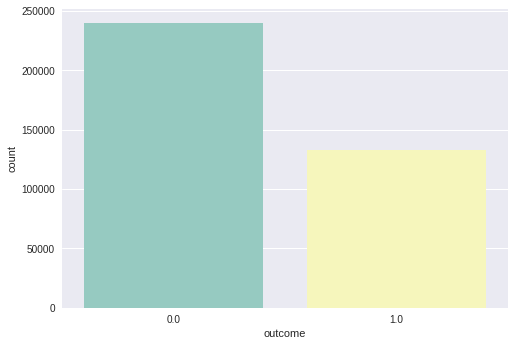

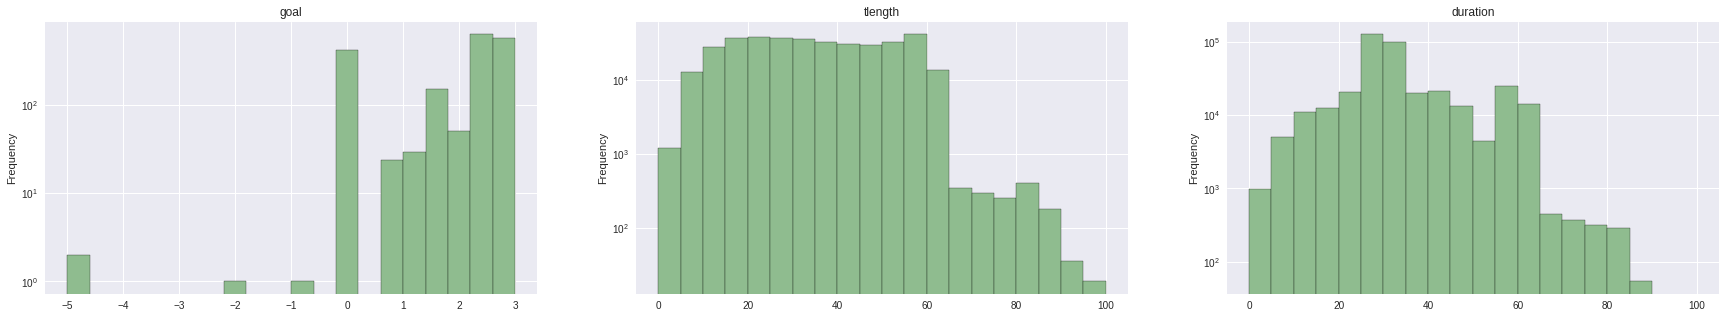

In [95]:
# JUST SOME DATA ANALYSIS, NOT FOR MODEL

sns.countplot(x = 'outcome', data = ks, palette = 'Set3')

# FIND OUTLIERS
fig, axs = plt.subplots(ncols=3, figsize=(30,5))

# goal, kickstarter maximum is 100.000
axs[0].set_title("goal")
ks['goal'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[-5,3], ax=axs[0])

# tlength
axs[1].set_title("tlength")
ks['tlength'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[1])

# duration
axs[2].set_title("duration")
ks['duration'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[2])


plt.show()

In [96]:
# CATEGORICAL ENCODING (one-hot encoding, label encoding, count encoding, target encoding, catboost encoding)

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# categorical features to be encoded
features = ['main_category', 'currency', 'country', 'category_country', 'category']

# encoders
l_encoder = LabelEncoder() # encode target labels with value between 0 and n_classes-1.
c_encoder = ce.CountEncoder() # replaces each categorical value with the number of times it appears in the dataset
t_encoder = ce.TargetEncoder(cols=features) # replaces a categorical value with the average value of the target for that value of the feature
cb_encoder = ce.CatBoostEncoder(cols=features) # for each row, the target probability is calculated only from the rows before it

# encoded features
l_encoded = ks[features].apply(l_encoder.fit_transform)
c_encoded = c_encoder.fit_transform(ks[features])
t_encoded = t_encoder.fit_transform(ks[features], ks['outcome'])
cb_encoded = cb_encoder.fit_transform(ks[features], ks['outcome'])

# drop categorical data since it is now encoded
ks.drop('currency', axis=1, inplace=True)
ks.drop('country', axis=1, inplace=True)
ks.drop('main_category', axis=1, inplace=True)
ks.drop('category', axis=1, inplace=True)
ks.drop('category_country', axis=1, inplace=True)

# drop non-used columns
ks.drop(['ID','name','backers', 'state', 'pledged', 'usd pledged', 'usd_pledged_real', 'launched', 'deadline'], axis=1, inplace=True)

# join numerical encodings with ks
data = ks.join(t_encoded)

# print result
print(data.head(5))
print(data.corr().abs()[['outcome']])
print(data.corr().sort_values('outcome', ascending=False).index)


        goal  usd_goal_real  outcome  tlength  duration  lyear  lmonth  lday  \
0   6.907755        1533.95      0.0       31        58   2015       8     1   
1  10.308953       30000.00      0.0       45        60   2017       9     5   
2  10.714418       45000.00      0.0       14        45   2013       1     5   
3   8.517193        5000.00      0.0       49        30   2012       3     5   
4   9.878170       19500.00      0.0       58        56   2015       7     5   

   lhour  l_is_weekend  dyear  dmonth  dday  project_competition  \
0     12             0   2015      10     4               1408.0   
1      4             1   2017      11     2                956.0   
2      0             1   2013       2     1                739.0   
3      3             1   2012       4     0                907.0   
4      8             1   2015       8     5               1429.0   

   category_competition  money_spent  main_category  currency   country  \
0             18.606111   2050685.7

In [97]:
# FEATURE SELECTION USING TREE CLASSIFIER, IS THIS EVEN USEFUL WHEN USING LOGISTIC REG?
##from sklearn.tree import DecisionTreeClassifier

#X = data.drop('outcome', axis = 1).values
#y = data['outcome']
#dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
#dt.fit(X,y)
#fi_col = []
#fi = []
#for i,column in enumerate(data.drop('outcome', axis = 1)):
#    fi_col.append(column)
#    fi.append(dt.feature_importances_[i])
#fi_col
#fi
#fi_df = zip(fi_col, fi)
#fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
#fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
#columns_to_keep = fi_df['Feature'][0:10]

#print(fi_df)


In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# reduce dataset size
data = data.sample(20000) 

# get predictors and outcome
x, y = data[['goal','duration','project_competition','category','category_country']], data['outcome']

# scaling (y already scaled)
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=list(x.columns))

# split data into training and testing set (60% vs 40%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

print("-"*35)
print("[60%] training set:\t", x_train.shape[0])
print("[40%] testing set:\t", x_test.shape[0])
print("-"*35)

ValueError: Boolean array expected for the condition, not float64

In [75]:
# CONFUSION MATRIX LOGISTIC REGRESSION
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Accuracy: 0.703 (+/- 0.015)
-----------------------------------
TRAINING SET
------------------------------------------------------------
[ACCURACY]	 70.28%
[PRECISION]	 61.64%
[RECALL]	 40.49%
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79      7789
         1.0       0.62      0.40      0.49      4211

    accuracy                           0.70     12000
   macro avg       0.67      0.63      0.64     12000
weighted avg       0.69      0.70      0.68     12000

[[6728 1061]
 [2506 1705]]
TESTING SET
------------------------------------------------------------
[ACCURACY]	 70.84%
[PRECISION]	 62.80%
[RECALL]	 42.58%
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79      5177
         1.0       0.63      0.43      0.51      2823

    accuracy                         

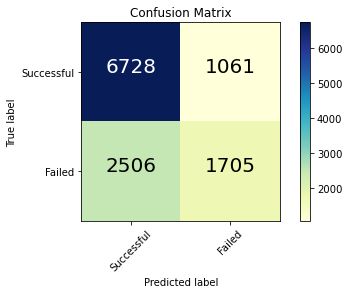

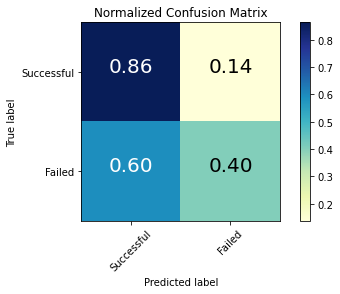

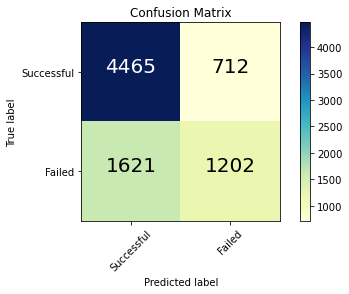

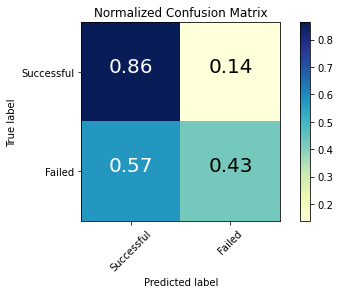

In [78]:
# [LOGISTIC REGRESSION]
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#to perform feature selection, model selection and parameter
#tuning. 

# cross validation with K folds
logistic = LogisticRegression(C=0.1, penalty="l1", solver='liblinear', random_state=1)
scores = cross_val_score(logistic, x_train, y_train, cv=10) # 10 folds
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2)) # computed 10 times, take mean

print("-"*35)
print("TRAINING SET")
predicted_train = cross_val_predict(logistic, x_train, y_train, cv=10)
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_train, predicted_train)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_train, predicted_train)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_train, predicted_train)*100))
print("-"*60)
print(metrics.classification_report(y_train, predicted_train))
print(confusion_matrix(y_train, predicted_train))


cnf_matrix = metrics.confusion_matrix(y_train, predicted_train)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')


print("TESTING SET")
predicted_test = cross_val_predict(logistic, x_test, y_test, cv=10)
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_test, predicted_test)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_test, predicted_test)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_test, predicted_test)*100))
print("-"*60)
print(metrics.classification_report(y_test, predicted_test))
print(confusion_matrix(y_test, predicted_test))

cnf_matrix = metrics.confusion_matrix(y_test, predicted_test)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')





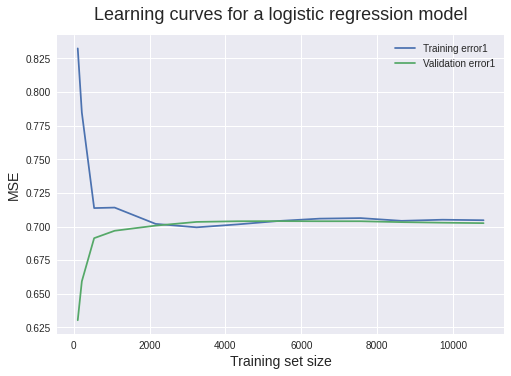

In [88]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(estimator = LogisticRegression(C=0.1), X=x_train, y=y_train, train_sizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv = 10)

train_scores_mean = train_scores.mean(axis = 1)
valid_scores_mean = valid_scores.mean(axis = 1)

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error1')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error1')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend()






In [90]:
# PARAMETER TUNING
from sklearn.linear_model import LogisticRegressionCV

C_List = np.geomspace(1e-5, 1e5, num=20)

# Logistic Reg CV
Log_reg3 = LogisticRegressionCV(random_state=15, Cs = C_List, solver ='lbfgs')
Log_reg3.fit(x_train, y_train)
print("The CA is:", Log_reg3.score(x_test, y_test))
pred_proba_t = Log_reg3.predict_proba(x_test)
log_loss3 = metrics.log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_loss3)

print("The optimal C parameter is: ", Log_reg3.C_)


#C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(x_train, y_train)
    score = log_reg2.score(x_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(x_test)
    log_loss2 = metrics.log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")
    
    y_pred = log_reg2.predict(x_train)
    cm = metrics.confusion_matrix(y_train, y_pred)
    #cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm, normalize=True, classes = model.classes_, title='Confusion matrix', cmap=plt.cm.YlGnBu)
    plt.show()




The CA is: 0.707375
The Logistic Loss is:  0.5579599261956356
The optimal C parameter is:  [20.69]
The CA of C parameter 1e-05 is 0.647125:
The Logg Loss of C parameter 1e-05 is 0.6401693126972613:



AttributeError: 'DataFrame' object has no attribute 'classes_'

In [ ]:
# DON'T EXECUTE! crashte bij mij idk waarom
# LightGBM
# Tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train.

import lightgbm as lgb
from sklearn import metrics

feature_cols = data.columns.drop('outcome')

dtrain = lgb.Dataset(data[feature_cols], label=data['outcome'])
dvalid = lgb.Dataset(data[feature_cols], label=data['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

# evaluation
print("-"*60)
print('Aread Under Curve (AUC): %.2f%%' %(metrics.roc_auc_score(test['outcome'], ypred)*100))
print("-"*60)

#76.06 (catboost)
#76.83 (target)
#76.34 (count)
#76.33 (label)


In [ ]:
# NAIVE BAYES ALGORITHM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn import metrics

# instantiate logistic regression model
model = GaussianNB()

# fit the model with the data
model.fit(x_train,y_train)

# make predictions
predict_test = model.predict(x_test)

# evaluation
print("-"*60)
print('Accuracy: %.2f%%' %(metrics.accuracy_score(y_test, predict_test)*100))
print('Precision: %.2f%%' %(metrics.precision_score(y_test, predict_test)*100))
print('Recall: %.2f%%' %(metrics.recall_score(y_test, predict_test)*100))
print("-"*60)


In [ ]:
# NEURAL NETWORK
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

#model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=32, epochs=50)

#model.summary()

#y_pred = model.predict_classes(x_test)
#print(metrics.accuracy_score(y_test, y_pred))



In [12]:
# SUPORRT VECTOR MACHINES
from sklearn import svm
from sklearn import metrics
from numpy import mean, std
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve, KFold

# Split dataset in train, validate, test sets
# x_train, x_valid, x_test, y_train, y_valid, y_test

# Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel, or radial basis function?

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


# Train the model using the training sets
clf.fit(x_train, y_train)

# model score: score(test samples, true labels for x)
print("-"*60)
print("Support Vector Machines Model Scores")
print('[TRAIN]\t %.2f%%' %(round(clf.score(x_train, y_train),5)*100))
#print('[VALID]\t %.2f%%' %(round(clf.score(x_valid, y_valid),5)*100))
print('[TEST]\t %.2f%%' %(round(clf.score(x_test, y_test),5)*100))
y_pred_test_SVM = clf.predict(x_test) 
print("-"*60)

# classification report: classification_report(y_true, y_pred)
print("Classification Report")
print(classification_report(y_test, y_pred_test_SVM))
print("-"*60)

# evaluationg the model
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred_valid))
#print("Precision:",metrics.precision_score(y_test, y_pred_valid))
#print("Recall:",metrics.recall_score(y_test, y_pred_valid))

Accuracy: 0.706 (0.006)
------------------------------------------------------------
Support Vector Machines Model Scores
[TRAIN]	 70.80%
[TEST]	 69.83%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.72      0.87      0.79     10206
         1.0       0.62      0.39      0.48      5682

    accuracy                           0.70     15888
   macro avg       0.67      0.63      0.63     15888
weighted avg       0.69      0.70      0.68     15888

------------------------------------------------------------


In [ ]:
# CONFUSION MATRIX SVM

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# confusion matrix: confusion_matrix(y_true, y_pred)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred_valid)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# evaluation of confusion matrix
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_valid, y_pred_valid_SVM)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_valid, y_pred_valid_SVM)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_valid, y_pred_valid_SVM)*100))
print("-"*60)